In [1]:
import os
import numpy as np
from PIL import Image
from skimage.segmentation import slic
from skimage.future import graph
from skimage.color import rgb2lab
from torchvision import transforms
from torch_geometric.data import Data
import torch

from torch.utils.data import random_split
from torch_geometric.data import InMemoryDataset
from torch_geometric.loader import DataLoader

from torch_geometric.nn import SplineConv, global_mean_pool

In [2]:
image_folder = "data"  # your plankton dataset path
image_size = 224
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

data_list = []

for class_idx, class_name in enumerate(sorted(os.listdir(image_folder))):
    class_dir = os.path.join(image_folder, class_name)
    if not os.path.isdir(class_dir): continue
    for filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, filename)
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')): continue

        image = Image.open(img_path).convert('RGB')
        image_tensor = transform(image)
        np_image = np.array(transforms.ToPILImage()(image_tensor))

        segments = slic(rgb2lab(np_image), n_segments=250, compactness=10, start_label=0)
        rag = graph.rag_mean_color(np_image, segments, mode='distance')

        node_feats = []
        centroids = {}
        for node in rag.nodes():
            mask = segments == node
            mean_rgb = np_image[mask].mean(axis=0)
            node_feats.append(mean_rgb)
            yx = np.argwhere(mask).mean(axis=0)
            centroids[node] = yx  # (row, col)

        x = torch.tensor(node_feats, dtype=torch.float)
        edges = list(rag.edges())
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

        # Compute pseudo-coordinates
        edge_attr = []
        for src, tgt in edges:
            src_pos = centroids[src]
            tgt_pos = centroids[tgt]
            diff = tgt_pos - src_pos  # (dy, dx)
            edge_attr.append(diff[::-1])  # reverse to (dx, dy)

        edge_attr = torch.tensor(edge_attr, dtype=torch.float)

        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=torch.tensor(class_idx - 1))
        data.image = np_image
        data.segments = segments
        data.rag = rag
        data_list.append(data)


/var/folders/yw/bg8nnxbs2tv4pz7s83z6djjw0000gn/T/ipykernel_47076/2951559084.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  x = torch.tensor(node_feats, dtype=torch.float)


KeyboardInterrupt: 

2145


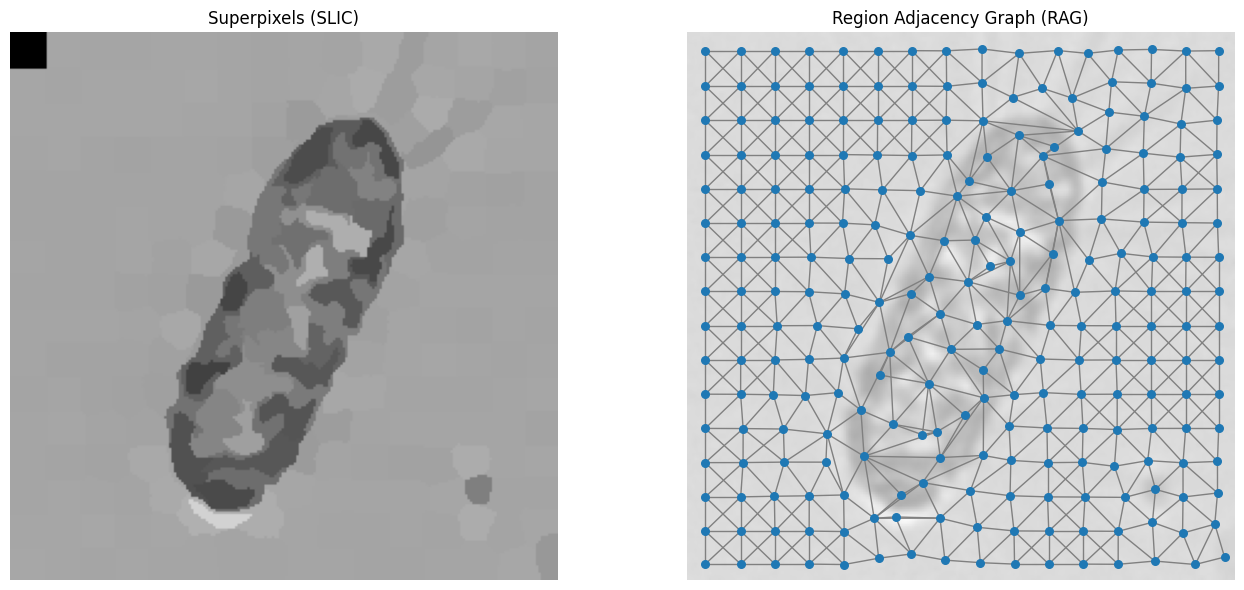

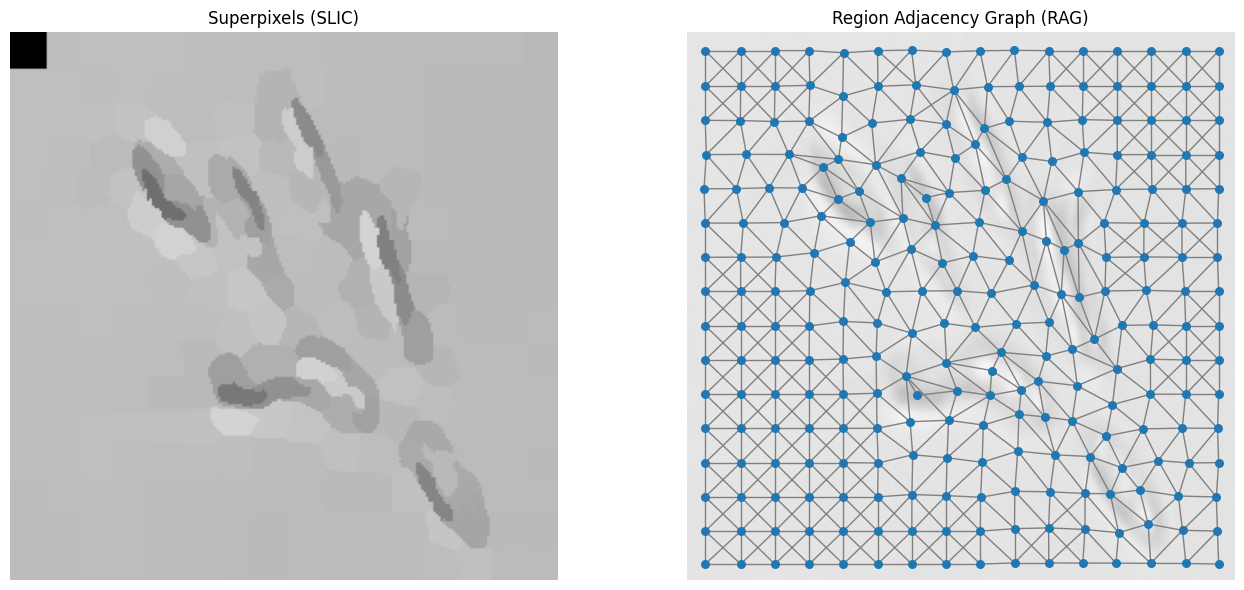

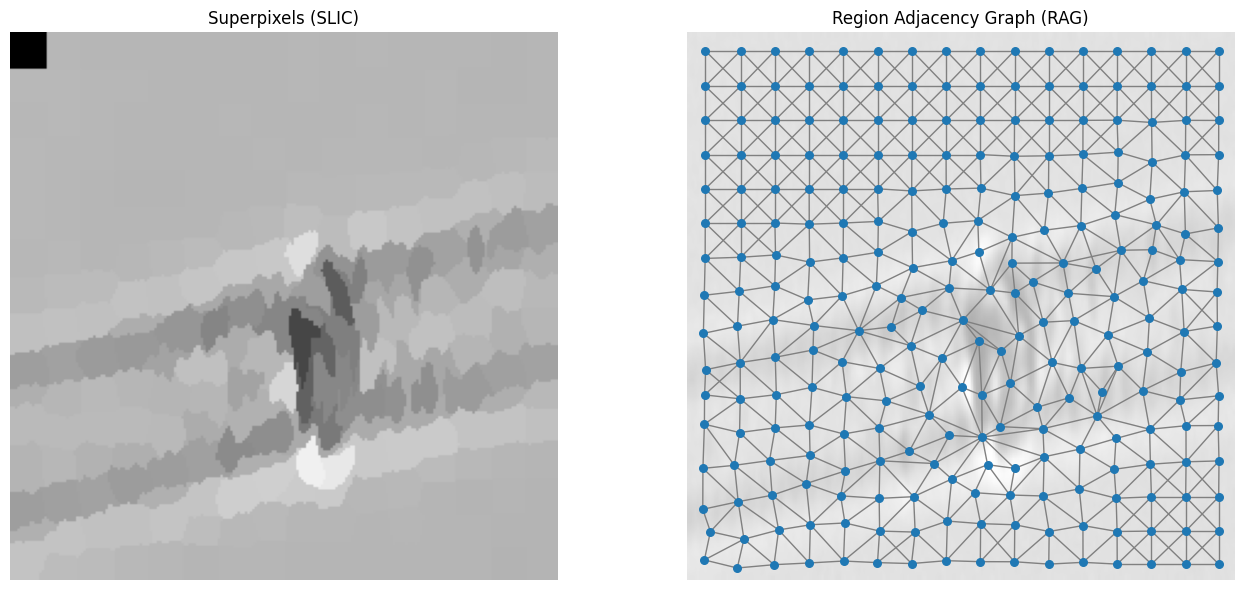

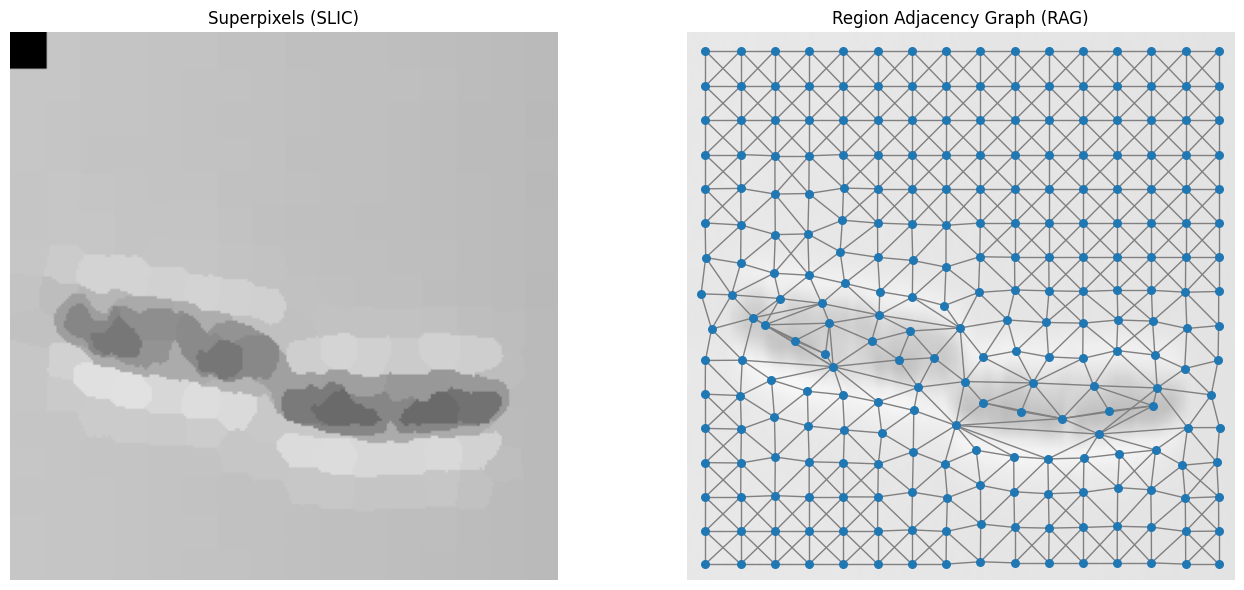

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from skimage.color import label2rgb

def visualize_graph_data(data):
    image = data.image
    segments = data.segments
    rag = data.rag

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    out = label2rgb(segments, image, kind='avg')
    axes[0].imshow(out)
    axes[0].set_title("Superpixels (SLIC)")
    axes[0].axis('off')

    pos = {n: np.array(np.mean(np.argwhere(segments == n), axis=0)[::-1]) for n in rag.nodes}
    nx.draw(rag, pos, ax=axes[1], node_size=30, with_labels=False, edge_color='gray')
    axes[1].imshow(image, alpha=0.4)
    axes[1].set_title("Region Adjacency Graph (RAG)")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Example
print(len(data_list))
visualize_graph_data(data_list[0])
visualize_graph_data(data_list[1000])
visualize_graph_data(data_list[700])
visualize_graph_data(data_list[2144])


In [ ]:
class PlanktonGraphDataset(InMemoryDataset):
    def __init__(self, data_list):
        super().__init__('.')
        self.data, self.slices = self.collate(data_list)
        
dataset = PlanktonGraphDataset(data_list)
print(dataset[0])

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


Data(x=[245, 3], edge_index=[2, 746], edge_attr=[746, 2], y=[1], image=[224, 224, 3], segments=[224, 224], rag=RAG with 245 nodes and 746 edges)


In [ ]:
class SplineCNN(torch.nn.Module):
    def __init__(self, in_channels=3, hidden_channels=32, out_channels=4):
        super().__init__()
        self.conv1 = SplineConv(in_channels, hidden_channels, dim=2, kernel_size=3)
        self.conv2 = SplineConv(hidden_channels, hidden_channels * 2, dim=2, kernel_size=3)
        self.fc1 = torch.nn.Linear(hidden_channels * 2, 128)
        self.fc2 = torch.nn.Linear(128, out_channels)

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.conv1(x, edge_index, edge_attr)
        x = torch.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = torch.relu(x)
        x = global_mean_pool(x, batch)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SplineCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

for epoch in range(1, 51):
    loss = train()
    val_acc = evaluate(val_loader)
    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f}")


/opt/miniconda3/envs/tf/lib/python3.9/site-packages/torch_geometric/nn/conv/spline_conv.py:133: UserWarning: We do not recommend using the non-optimized CPU version of `SplineConv`. If possible, please move your data to GPU.
  warnings.warn(


IndexError: start out of range (expected to be in range of [-1641248, 1641248], but got 9205357640488583168)